In [1]:
import sys
# sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
from scipy import ndimage, signal, stats
from skimage.measure import label
from matplotlib import colors, patches
import matplotlib.pyplot as plt
from tifffile import imsave
import colorcet as cc
from cycler import cycler
import os
from scipy import interpolate, optimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import mat73
import pandas as pd
import parse
from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
from spikecounter.analysis import stats as sstats
from skimage import draw, morphology, transform, filters
import importlib
# plt.style.use("../bio_pubs_presentation.mplstyle")
ss = StandardScaler()

In [31]:
importlib.reload(images)

<module 'spikecounter.analysis.images' from 'C:\\Users\\labmember\\Documents\\GitHub\\SpikeCounter\\spikecounter\\analysis\\images.py'>

In [2]:
rootdir = "F:/Bill Jia/Optopatch/20230312/"
# rootdir = "/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing"
filename = "120038A3_fast"
crosstalk_channel = "None"

## Fast STA

In [2]:
def generate_invalid_frame_indices(stim_trace, dt_frame):
    invalid_indices_daq = np.argwhere(stim_trace > 0).ravel()
    if np.sum(np.diff(invalid_indices_daq)<2) == 0:
        invalid_indices_camera = np.unique(np.concatenate((invalid_indices_daq, invalid_indices_daq+1)))
    else:
        invalid_indices_camera = invalid_indices_daq
    return invalid_indices_camera

In [409]:
crosstalk_channel = "enable488"

In [410]:
img, expt_data = images.load_image(rootdir, filename, raw=True)
trace_dict, dt_frame = utils.traces_to_dict(expt_data)
fs = 1/dt_frame

In [411]:
invalid_indices = generate_invalid_frame_indices(trace_dict[crosstalk_channel], dt_frame)


In [412]:
factor = 4
downsampled = transform.downscale_local_mean(img, (1,factor,factor))
# img = img[:,::factor,:]
# img = img[:,:,::factor]

In [413]:
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
# plt.imshow(target_img_space)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-downsampled.shape[1])//2, (target_img_space.shape[1]-downsampled.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
target_img_space = target_img_space.astype(bool)

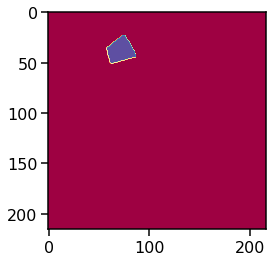

In [414]:
plt.imshow(target_img_space)

(array([2152., 6386., 7217., 6189., 7770., 7970., 4408., 3356., 1157.,
          51.]),
 array([131.40702083, 142.94171458, 154.47640833, 166.01110208,
        177.54579583, 189.08048958, 200.61518333, 212.14987708,
        223.68457083, 235.21926458, 246.75395833]),
 <BarContainer object of 10 artists>)

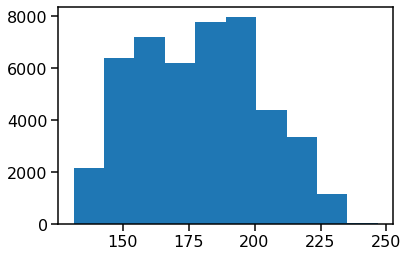

In [415]:
mean_img = downsampled.mean(axis=0)
plt.hist(mean_img.ravel())

In [416]:
# invalid_mask = np.zeros(img.shape[0], dtype=bool)
# invalid_indices = invalid_indices[invalid_indices < img.shape[0]]
# invalid_mask[invalid_indices] = True
# stim_frames_removed = utils.interpolate_invalid_values(img, invalid_mask)

In [417]:
nsamps = (int(2*fs)//2)*2 +1
pb_corrected_img = images.correct_photobleach(downsampled, mask=None, method="localmin", nsamps=nsamps)


(3000, 216, 216)


In [418]:
dFF = images.get_image_dFF(pb_corrected_img)

In [419]:
target_trace = images.extract_mask_trace(dFF, mask=target_img_space)

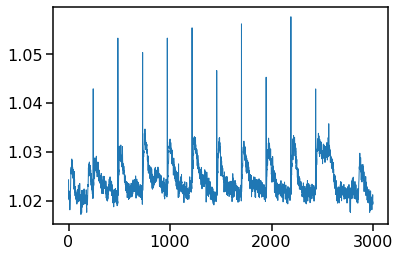

In [420]:
plt.plot(target_trace)

In [421]:
sta = images.spike_triggered_average_video(dFF, invalid_indices+1,0,200)

In [422]:
target_sta = images.extract_mask_trace(sta, mask=target_img_space)

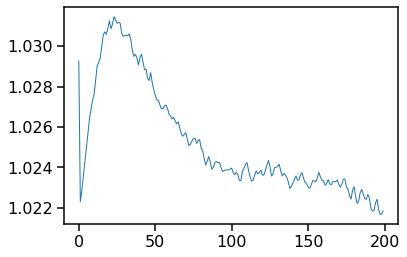

In [423]:
plt.plot(target_sta)

In [424]:
skio.imsave(os.path.join(output_folder, "%s_sta.tif" % filename), sta)

C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\3942651040.py:1: UserWarning: F:/Bill Jia/Optopatch/20220306/132933E4_target3_50Hz_sta.tif is a low contrast image
  skio.imsave(os.path.join(output_folder, "%s_sta.tif" % filename), sta)


## Convert to tif, downsample and denoise

In [3]:
rootdir = "F:/Bill Jia/Optopatch/20230312/"
# rootdir = "/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing"
filename = "120038A3_fast"
crosstalk_channel = "None"

In [5]:
img, expt_data = images.load_image(rootdir, filename, raw=True)

In [6]:
scale_factor = 8
output_folder = rootdir
n_pcs = 30
remove_from_start = 200
remove_from_end = 0
skewness_threshold = 0
left_shoulder = 16
right_shoulder = 19
trace_dict, t = utils.traces_to_dict(expt_data)
dt_frame = np.mean(np.diff(t))
fs = 1/dt_frame

In [7]:
os.makedirs(os.path.join(output_folder, "denoised"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "downsampled"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "stim_frames_removed"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "corrected"), exist_ok=True)

In [9]:
trimmed = img[remove_from_start:img.shape[0]-remove_from_end]
downsampled = images.downsample_video(trimmed, scale_factor)
# skio.imsave(os.path.join(output_folder, "downsampled", "%s.tif" % expt_name), np.round(downsampled).astype(np.uint16))


In [10]:
downsampled.shape

(5641, 128, 128)

In [11]:
nsamps = (int(2*fs)//2)*2 +1
pb_corrected_img = images.correct_photobleach(downsampled, mask=None, method="localmin", nsamps=nsamps)
# skio.imsave(os.path.join(output_folder, "corrected", "%s.tif" % expt_name), pb_corrected_img)

In [13]:
mean_img = pb_corrected_img.mean(axis=0)

# Zero the mean over time
t_zeroed = pb_corrected_img - mean_img
data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))

# bandpass to get rid of BU noise
if left_shoulder < fs/2:
    if right_shoulder == -1:
        sos = signal.butter(5,[left_shoulder], output="sos", fs=fs)
    else:
        sos = signal.butter(5,[left_shoulder,right_shoulder], btype="bandstop", output="sos", fs=fs)
    data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
else:
    data_matrix_filtered = data_matrix

# SVD
denoised = sstats.denoise_svd(data_matrix_filtered, n_pcs, skewness_threshold=skewness_threshold)
denoised = denoised.reshape(downsampled.shape)

# Add back DC offset for the purposes of comparing noise to mean intensity
denoised += mean_img
skio.imsave(os.path.join(output_folder, "denoised", "%s.tif" % filename), denoised.astype(np.float32))


c:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


## Load image

In [14]:
print(filename)
# img, expt_data = images.load_image(rootdir, filename, subfolder="denoised")
img = images.correct_photobleach(denoised, method="linear")
print(img.shape)

120038A3_fast
(5641, 128, 128)


In [15]:
dt_dict, t = utils.traces_to_dict(expt_data)
dt = np.mean(np.diff(t))

In [136]:
center_mask = np.zeros((img.shape[1], img.shape[2]), dtype=bool)
center_mask[40:60,40:50] = True


c:\Users\labmember\Documents\GitHub\SpikeCounter\spikecounter\analysis\images.py:1556: UserWarning: F:/Bill Jia/Optopatch/20230312/analysis\120038A3_fast\dFF.tif is a low contrast image
  skio.imsave(os.path.join(savedir, "dFF.tif"), dFF_img.astype(np.float32))
c:\Users\labmember\Documents\GitHub\SpikeCounter\spikecounter\analysis\images.py:1641: UserWarning: F:/Bill Jia/Optopatch/20230312/analysis\120038A3_fast\sta.tif is a low contrast image
  skio.imsave(os.path.join(savedir, "sta.tif"), sta)


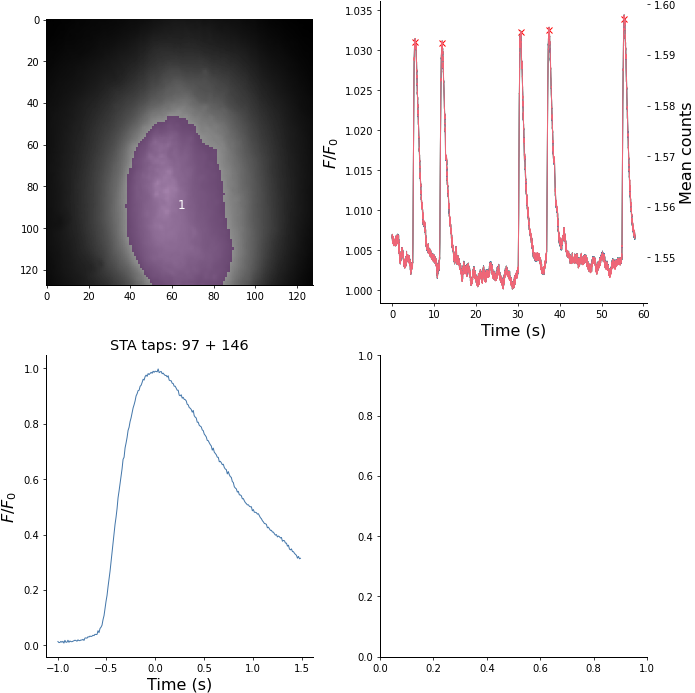

In [20]:
sta, spike_images = images.image_to_sta(img, fs=1/dt, plot=True, prom_pct=80, sta_bounds=(int(1//dt), int(1.5//dt)),\
                   savedir=os.path.join(rootdir, "analysis", filename), offset=200, full_output=True)

In [21]:
utils.display_zstack(sta[:,:,:, np.newaxis], c=0, pct_cutoffs=[5,99])

interactive(children=(IntSlider(value=121, description='z', max=242), Dropdown(description='c', options=('all'…

(array([1.02000000e+02, 6.59515937e+01, 1.13422167e+00, 2.88824786e-04,
        6.30735603e+01]),
 <AxesSubplot:>)

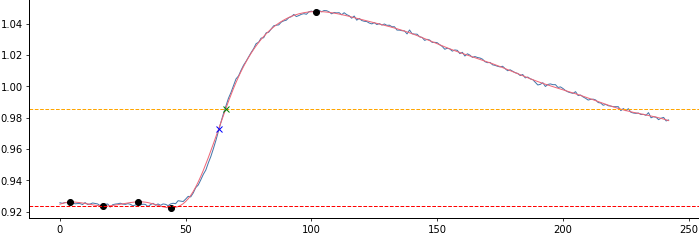

In [22]:
trace = sta[:,60, 50]
s = 0.05
n_knots = 15
knots = np.linspace(0, sta.shape[0]-1, num=n_knots)[1:-1]
images.spline_fit_single_trace(trace, s, knots, plot=True)

In [23]:
beta, smoothed_vid = images.spline_timing(sta, s=0.05, n_knots=15)

c:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
c:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:402: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
c:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: Mean 

In [24]:
os.makedirs(os.path.join(rootdir, "analysis", filename, "individual_spikes"), exist_ok=True)
skio.imsave(os.path.join(rootdir, "analysis", filename, "spline_smoothed_vid.tif"), smoothed_vid)
np.savez(os.path.join(rootdir, "analysis", "%s_snapt_denoised.npz") % filename,\
         beta=beta)

C:\Users\labmember\AppData\Local\Temp\ipykernel_13308\1334898136.py:2: UserWarning: F:/Bill Jia/Optopatch/20230312/analysis\120038A3_fast\spline_smoothed_vid.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", filename, "spline_smoothed_vid.tif"), smoothed_vid)


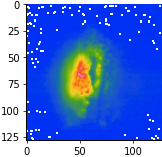

In [25]:
amplitude = beta[2,:,:]
plt.imshow(amplitude)

In [26]:
amplitude_2048 = np.zeros((2048, 2048))
amplitude_rescaled = transform.rescale(beta[2,:,:], scale_factor)
offset = [(2048 - amplitude_rescaled.shape[0])//2, \
          (2048 - amplitude_rescaled.shape[1])//2]
amplitude_2048[offset[0]:-offset[0],offset[1]:-offset[1]] = amplitude_rescaled-1

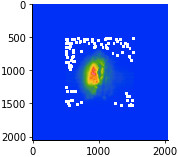

In [27]:
plt.imshow(amplitude_2048)

In [29]:
skio.imsave(os.path.join(rootdir, "Snaps", "%s_spike_amplitude.tiff" % filename), amplitude_2048)

C:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_opening`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)
C:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


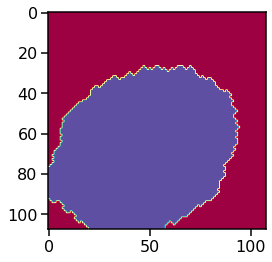

In [145]:
amplitude = beta[2,:,:]
amplitude_nanr = np.copy(amplitude)
minval = np.nanmin(amplitude)
amplitude_nanr[np.isnan(amplitude)] = minval
thresh = np.percentile(amplitude_nanr,40)
# thresh = filters.threshold_otsu(amplitude_nanr)
mask = amplitude_nanr>thresh
mask = morphology.binary_opening(mask, selem=morphology.disk(2))
mask = morphology.binary_closing(mask, selem=morphology.disk(2))
plt.imshow(mask)

In [30]:
hm_smoothed, dv_smoothed = images.process_isochrones(beta, dt, threshold_mode="snr", 
                                opening_size=2, closing_size=2)

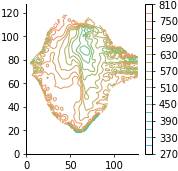

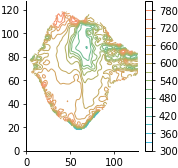

In [32]:
fig1, ax1 = plt.subplots(figsize=(2.5,2.75))

im = ax1.contour(hm_smoothed, vmin=np.percentile(hm_smoothed[~np.isnan(hm_smoothed)],0), \
               vmax=np.percentile(hm_smoothed[~np.isnan(hm_smoothed)],99), levels=16, \
                 cmap = plt.get_cmap("cet_CET_I1"))
plt.colorbar(im)
fig1, ax1 = plt.subplots(figsize=(2.5,2.75))

im = ax1.contour(dv_smoothed, vmin=np.percentile(dv_smoothed[~np.isnan(dv_smoothed)],0), \
               vmax=np.percentile(dv_smoothed[~np.isnan(dv_smoothed)],99), levels=16, \
                 cmap = plt.get_cmap("cet_CET_I1"))
plt.colorbar(im)

In [36]:
pmin, pmax = np.percentile(hm_smoothed[~np.isnan(hm_smoothed)],[0.5, 95])
sigma = 1
hm_time_smoothed = np.copy(hm_smoothed)
hm_time_smoothed[np.isnan(hm_time_smoothed)] = pmax
hm_time_smoothed = ndimage.gaussian_filter(hm_time_smoothed, sigma)
try:
    focus_mask = hm_time_smoothed < np.percentile(hm_time_smoothed, 10)
    labels, num = label(focus_mask, return_num=True)
    region_sizes = [np.sum(1/(hm_time_smoothed[labels==i]+0.01)) for i in np.arange(1, num+1)]
    single_region_mask = labels == (np.argmax(region_sizes)+1)
    masked_hm_time = np.ma.masked_array(hm_time_smoothed, ~single_region_mask)
    min_index = np.unravel_index(np.ma.argmin(masked_hm_time), hm_smoothed.shape)
except Exception as e:
    print(e)
    min_index = [np.nan, np.nan]

C:\Users\labmember\AppData\Local\Temp\ipykernel_13308\1881047371.py:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im, label="ms", aspect=15, shrink=0.75)


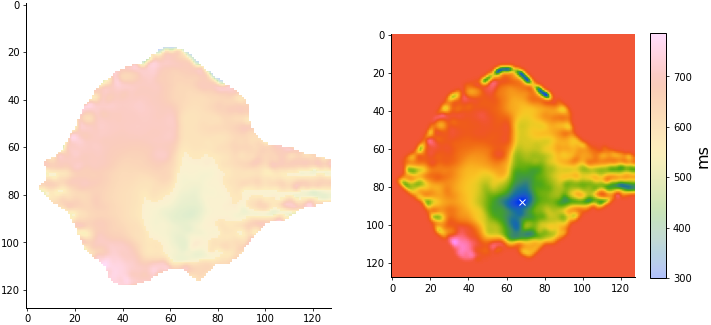

In [37]:
fig1, axes = plt.subplots(1,2, figsize=(12,6))
axes = axes.ravel()
im = axes[0].imshow(hm_smoothed, alpha=0.3)
axes[0].imshow(np.ma.masked_array(focus_mask, ~focus_mask), alpha=0.3, cmap="Blues")
plt.colorbar(im, label="ms", aspect=15, shrink=0.75)
#         freq = n_peaks_by_embryo[e][mask_idx]/30
axes[1].imshow(hm_time_smoothed)
#         im = axes.contour(np.flipud(hm_time)*1000)
axes[1].plot(min_index[1], min_index[0], "wx")

### Draw mask targeting initiation site

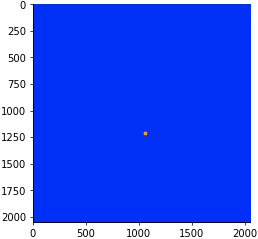

In [35]:
nrows = 2048
ncols = 2048
radius = 15

target_mask = np.zeros((nrows, ncols), dtype=bool)
offset = [(nrows - hm_time_smoothed.shape[0]*scale_factor)//2, \
          (ncols - hm_time_smoothed.shape[1]*scale_factor)//2]
rr, cc = draw.disk((offset[0] + min_index[0]*scale_factor, offset[1] + min_index[1]*scale_factor), radius)
target_mask[rr,cc] = True

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(target_mask)

In [151]:
skio.imsave(os.path.join(rootdir, "analysis", filename, "%s_locus_target.tif" % filename), target_mask)
skio.imsave(os.path.join(rootdir, "Snaps", "%s_locus_target.tiff" % filename), target_mask)

C:\Users\labmember\AppData\Local\Temp\ipykernel_45008\2745475218.py:1: UserWarning: F:/Bill Jia/Optopatch/20220407/analysis\111909E8_endogenous\111909E8_endogenous_locus_target.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skio.imsave(os.path.join(rootdir, "analysis", filename, "%s_locus_target.tif" % filename), target_mask)
C:\Users\labmember\AppData\Local\Temp\ipykernel_45008\2745475218.py:1: UserWarning: F:/Bill Jia/Optopatch/20220407/analysis\111909E8_endogenous\111909E8_endogenous_locus_target.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", filename, "%s_locus_target.tif" % filename), target_mask)
C:\Users\labmember\AppData\Local\Temp\ipykernel_45008\2745475218.py:2: UserWarning: F:/Bill Jia/Optopatch/20220407/Snaps\111909E8_endogenous_locus_target.tiff is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_a